In [19]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import matplotlib as plt
import seaborn as sns
import time
import pandas as pd
import re

In [ ]:


def setup_driver():
    """Configurar el driver de Selenium"""
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Comenta para ver el navegador
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")
    chrome_options.add_argument("--window-size=1920,1080")
    
    driver = webdriver.Chrome(options=chrome_options)
    return driver

def hacer_scroll_completo(driver):
    """Hacer scroll completo para cargar todas las propiedades"""
    print("🔄 Haciendo scroll completo...")
    
    last_height = driver.execute_script("return document.body.scrollHeight")
    intentos = 0
    max_intentos = 5
    
    while intentos < max_intentos:
        # Scroll al final
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        
        # Scroll adicional suave
        for i in range(2):
            driver.execute_script(f"window.scrollBy(0, 500);")
            time.sleep(0.5)
        
        # Calcular nueva altura
        new_height = driver.execute_script("return document.body.scrollHeight")
        
        if new_height == last_height:
            intentos += 1
        else:
            intentos = 0
            
        last_height = new_height
        
        if intentos >= 2:  # Si no hay cambio después de 2 intentos, salir
            break

def encontrar_y_hacer_click_pagina(driver, numero_pagina):
    """Encontrar y hacer click en un número de página específico"""
    print(f"🔍 Buscando página {numero_pagina}...")
    
    # Lista de selectores para probar
    selectors = [
        f"//a[text()='{numero_pagina}']",
        f"//button[text()='{numero_pagina}']",
        f"//span[text()='{numero_pagina}']",
        f"//*[contains(@class, 'page') and text()='{numero_pagina}']",
        f"//*[contains(@class, 'pagination')]//a[text()='{numero_pagina}']",
        f"//*[contains(@class, 'pagination')]//button[text()='{numero_pagina}']",
        f"//*[contains(@class, 'pagination')]//span[text()='{numero_pagina}']",
    ]
    
    for selector in selectors:
        try:
            elemento = WebDriverWait(driver, 3).until(
                EC.element_to_be_clickable((By.XPATH, selector))
            )
            print(f"✅ Encontrada página {numero_pagina} con selector: {selector}")
            
            # Scroll al elemento
            driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", elemento)
            time.sleep(1)
            
            # Verificar que no es la página actual
            if elemento.get_attribute("class") and "active" in elemento.get_attribute("class"):
                print(f"ℹ️ La página {numero_pagina} ya está activa")
                return False
            
            # Hacer click
            driver.execute_script("arguments[0].click();", elemento)
            print(f"✅ Click exitoso en página {numero_pagina}")
            return True
        except:
            continue
    
    # Buscar en contenedores de paginación
    contenedores = [
        "//div[contains(@class, 'pagination')]",
        "//nav[contains(@class, 'pagination')]",
        "//ul[contains(@class, 'pagination')]",
        "//div[contains(@class, 'results-pagination')]",
    ]
    
    for contenedor in contenedores:
        try:
            pagination_container = driver.find_element(By.XPATH, contenedor)
            print(f"✅ Encontrado contenedor: {contenedor}")
            
            # Buscar todos los elementos dentro del contenedor
            elementos = pagination_container.find_elements(By.XPATH, ".//*")
            
            for elemento in elementos:
                if elemento.text.strip() == str(numero_pagina):
                    # Verificar que no es la página actual
                    if elemento.get_attribute("class") and "active" in elemento.get_attribute("class"):
                        print(f"ℹ️ La página {numero_pagina} ya está activa")
                        return False
                    
                    driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", elemento)
                    time.sleep(1)
                    driver.execute_script("arguments[0].click();", elemento)
                    print(f"✅ Click en página {numero_pagina} desde contenedor")
                    return True
        except:
            continue
    
    print(f"❌ No se pudo encontrar la página {numero_pagina}")
    return False

def verificar_pagina_cargada(driver, numero_pagina, timeout=15):
    """Verificar que la página se cargó correctamente"""
    try:
        # Esperar a que carguen las propiedades
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.CLASS_NAME, "property-card__container"))
        )
        
        # Verificar que hay propiedades
        propiedades = driver.find_elements(By.CLASS_NAME, "property-card__container")
        if propiedades:
            print(f"✅ Página {numero_pagina} cargada correctamente ({len(propiedades)} propiedades)")
            return True
        
        print(f"❌ Página {numero_pagina} cargada pero sin propiedades")
        return False
        
    except TimeoutException:
        print(f"❌ Timeout esperando página {numero_pagina}")
        return False

def extraer_datos_propiedad(card):
    """Extraer datos detallados de una propiedad"""
    try:
        data = {}
        
        # Titulo
        try:
            titulo_elem = card.find_element(By.CLASS_NAME, "property-card__detail-title")
            data['titulo'] = titulo_elem.text.strip()
        except:
            data['titulo'] = ""
        
        # Ubicación
        try:
            ubicacion_elem = card.find_element(By.CLASS_NAME, "property-card__detail-top__left")
            data['ubicacion'] = ubicacion_elem.text.strip()
        except:
            data['ubicacion'] = ""
        
        # Precio
        try:
            precio_elem = card.find_element(By.CLASS_NAME, "property-card__detail-price")
            data['precio'] = precio_elem.text.strip()
        except:
            data['precio'] = ""
        
        # Características
        try:
            specs_elem = card.find_element(By.CLASS_NAME, "property-card__detail-specs")
            specs_text = specs_elem.text.strip()
            data['caracteristicas'] = specs_text
            
            # Extraer valores específicos
            area_match = re.search(r'(\d+)\s*m²', specs_text)
            data['area_m2'] = area_match.group(1) if area_match else ""
            
            hab_match = re.search(r'(\d+)\s*hab', specs_text)
            data['habitaciones'] = hab_match.group(1) if hab_match else ""
            
            bano_match = re.search(r'(\d+)\s*bañ', specs_text)
            data['banos'] = bano_match.group(1) if bano_match else ""
            
            parq_match = re.search(r'(\d+)\s*par', specs_text)
            data['parqueaderos'] = parq_match.group(1) if parq_match else ""
            
        except:
            data['caracteristicas'] = ""
            data['area_m2'] = ""
            data['habitaciones'] = ""
            data['banos'] = ""
            data['parqueaderos'] = ""
        
        # URL
        try:
            link_elem = card.find_element(By.TAG_NAME, "a")
            data['url'] = link_elem.get_attribute("href")
            if data['url']:
                codigo_match = re.search(r'/([A-Z0-9-]+)$', data['url'])
                data['codigo'] = codigo_match.group(1) if codigo_match else ""
            else:
                data['codigo'] = ""
        except:
            data['url'] = ""
            data['codigo'] = ""
        
        return data if data['titulo'] else None
        
    except Exception as e:
        print(f"Error extrayendo propiedad: {e}")
        return None

def scrape_pagina(driver, numero_pagina):
    """Extraer todas las propiedades de una página específica"""
    print(f"\n📄 PROCESANDO PÁGINA {numero_pagina}")
    print("-" * 50)
    
    start_time = time.time()
    
    # Hacer scroll completo
    hacer_scroll_completo(driver)
    time.sleep(2)
    
    # Encontrar todas las propiedades
    try:
        property_cards = driver.find_elements(By.CLASS_NAME, "property-card__container")
        print(f"📊 Encontradas {len(property_cards)} propiedades")
    except:
        print("❌ No se pudieron encontrar propiedades")
        return []
    
    propiedades_pagina = []
    propiedades_extraidas = 0
    
    for i, card in enumerate(property_cards, 1):
        try:
            propiedad = extraer_datos_propiedad(card)
            if propiedad:
                propiedad['pagina'] = numero_pagina
                propiedad['numero_en_pagina'] = i
                propiedades_pagina.append(propiedad)
                propiedades_extraidas += 1
                
                # Mostrar progreso cada 10 propiedades
                if i % 10 == 0:
                    print(f"   📦 Extraídas {i}/{len(property_cards)} propiedades...")
                    
        except Exception as e:
            continue
    
    end_time = time.time()
    tiempo_pagina = end_time - start_time
    
    print(f"✅ Página {numero_pagina} completada: {propiedades_extraidas} propiedades ({tiempo_pagina:.1f}s)")
    
    return propiedades_pagina

def scrape_100_paginas(max_paginas=100):
    """Scraping automático de hasta 100 páginas"""
    driver = setup_driver()
    todas_propiedades = []
    
    try:
        # Página 1 - Navegación inicial
        url = "https://www.metrocuadrado.com/inmuebles/arriendo/medellin/"
        print(f"🌐 Accediendo a página 1: {url}")
        driver.get(url)
        
        # Esperar carga inicial
        if not verificar_pagina_cargada(driver, 1):
            print("❌ Error cargando página 1")
            return []
        
        pagina_actual = 1
        paginas_fallidas = 0
        max_fallos_consecutivos = 3
        
        while pagina_actual <= max_paginas and paginas_fallidas < max_fallos_consecutivos:
            print(f"\n{'='*60}")
            print(f"🎯 PÁGINA ACTUAL: {pagina_actual}")
            print(f"📈 PROGRESO: {pagina_actual}/{max_paginas}")
            print(f"📊 TOTAL EXTRAÍDO: {len(todas_propiedades)} propiedades")
            print(f"{'='*60}")
            
            # Extraer página actual
            propiedades_pagina = scrape_pagina(driver, pagina_actual)
            
            if propiedades_pagina:
                todas_propiedades.extend(propiedades_pagina)
                paginas_fallidas = 0  # Resetear contador de fallos
                
                # Guardar progreso cada 5 páginas
                if pagina_actual % 5 == 0:
                    guardar_progreso(todas_propiedades, pagina_actual)
            else:
                paginas_fallidas += 1
                print(f"❌ Fallo en página {pagina_actual} ({paginas_fallidas}/{max_fallos_consecutivos})")
            
            # Intentar navegar a la siguiente página (excepto en la última iteración)
            if pagina_actual < max_paginas:
                siguiente_pagina = pagina_actual + 1
                print(f"\n🔄 Intentando navegar a página {siguiente_pagina}...")
                
                if encontrar_y_hacer_click_pagina(driver, siguiente_pagina):
                    # Esperar carga de nueva página
                    time.sleep(5)
                    
                    if verificar_pagina_cargada(driver, siguiente_pagina):
                        pagina_actual = siguiente_pagina
                    else:
                        paginas_fallidas += 1
                        print(f"❌ Error cargando página {siguiente_pagina}")
                else:
                    paginas_fallidas += 1
                    print(f"❌ No se pudo encontrar página {siguiente_pagina}")
            else:
                print("✅ Límite de páginas alcanzado")
                break
            
            # Pequeña pausa entre páginas para no sobrecargar el servidor
            time.sleep(2)
        
        if paginas_fallidas >= max_fallos_consecutivos:
            print(f"\n⚠️  Detenido por {max_fallos_consecutivos} fallos consecutivos")
                
    except Exception as e:
        print(f"❌ Error fatal: {e}")
    finally:
        driver.quit()
    
    return todas_propiedades

def guardar_progreso(propiedades, pagina_actual):
    """Guardar progreso temporal"""
    if propiedades:
        df = pd.DataFrame(propiedades)
        archivo_temp = f"progreso_pagina_{pagina_actual}.xlsx"
        df.to_excel(archivo_temp, index=False)
        print(f"💾 Progreso guardado: {archivo_temp}")

def guardar_resultados_finales(propiedades):
    """Guardar resultados finales"""
    if not propiedades:
        print("❌ No hay datos para guardar")
        return
    
    df = pd.DataFrame(propiedades)
    
    # Estadísticas
    print(f"\n{'='*50}")
    print("📊 ESTADÍSTICAS FINALES")
    print(f"{'='*50}")
    print(f"Total propiedades: {len(propiedades):,}")
    
    if 'pagina' in df.columns:
        paginas = df['pagina'].unique()
        print(f"Páginas procesadas: {len(paginas)}")
        print(f"Rango de páginas: {min(paginas)} - {max(paginas)}")
        
        # Propiedades por página
        for pagina in sorted(paginas)[:10]:  # Mostrar primeras 10 páginas
            count = len(df[df['pagina'] == pagina])
            print(f"  Página {pagina}: {count} propiedades")
        
        if len(paginas) > 10:
            print(f"  ... y {len(paginas) - 10} páginas más")
    
    # Guardar en múltiples formatos
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    archivo_base = f"propiedades_metrocuadrado_{timestamp}"
    
    formats = {
        'excel': f'{archivo_base}.xlsx',
        'csv': f'{archivo_base}.csv',
        'json': f'{archivo_base}.json'
    }
    
    for formato, archivo in formats.items():
        try:
            if formato == 'excel':
                df.to_excel(archivo, index=False)
            elif formato == 'csv':
                df.to_csv(archivo, index=False, encoding='utf-8-sig')
            elif formato == 'json':
                df.to_json(archivo, orient='records', indent=2, force_ascii=False)
            print(f"✅ Guardado: {archivo}")
        except Exception as e:
            print(f"❌ Error guardando {archivo}: {e}")

def main():
    print("🚀 INICIANDO SCRAPING DE 100 PÁGINAS")
    print("⏰ Este proceso puede tomar varias horas...")
    print("💡 Recomendado: Ejecutar en headless mode para mejor rendimiento")
    print("🛑 Puedes detener en cualquier momento con Ctrl+C\n")
    
    start_time = time.time()
    
    try:
        # Scraping de hasta 100 páginas
        propiedades = scrape_100_paginas(max_paginas=200)
        
        end_time = time.time()
        tiempo_total = end_time - start_time
        horas = int(tiempo_total // 3600)
        minutos = int((tiempo_total % 3600) // 60)
        segundos = int(tiempo_total % 60)
        
        print(f"\n🎉 SCRAPING COMPLETADO!")
        print(f"⏱️  Tiempo total: {horas:02d}:{minutos:02d}:{segundos:02d}")
        
        if propiedades:
            guardar_resultados_finales(propiedades)
        else:
            print("❌ No se extrajeron propiedades")
            
    except KeyboardInterrupt:
        print(f"\n🛑 Scraping interrumpido por el usuario")
        print(f"📊 Propiedades extraídas hasta el momento: {len(propiedades) if 'propiedades' in locals() else 0}")
        if 'propiedades' in locals() and propiedades:
            guardar_resultados_finales(propiedades)

if __name__ == "__main__":
    main()

🚀 INICIANDO SCRAPING DE 100 PÁGINAS
⏰ Este proceso puede tomar varias horas...
💡 Recomendado: Ejecutar en headless mode para mejor rendimiento
🛑 Puedes detener en cualquier momento con Ctrl+C

🌐 Accediendo a página 1: https://www.metrocuadrado.com/inmuebles/arriendo/medellin/
✅ Página 1 cargada correctamente (9 propiedades)

🎯 PÁGINA ACTUAL: 1
📈 PROGRESO: 1/200
📊 TOTAL EXTRAÍDO: 0 propiedades

📄 PROCESANDO PÁGINA 1
--------------------------------------------------
🔄 Haciendo scroll completo...
📊 Encontradas 68 propiedades
   📦 Extraídas 10/68 propiedades...
   📦 Extraídas 20/68 propiedades...
   📦 Extraídas 30/68 propiedades...
   📦 Extraídas 40/68 propiedades...
   📦 Extraídas 50/68 propiedades...
   📦 Extraídas 60/68 propiedades...
✅ Página 1 completada: 68 propiedades (18.1s)

🔄 Intentando navegar a página 2...
🔍 Buscando página 2...
✅ Encontrada página 2 con selector: //a[text()='2']
✅ Click exitoso en página 2
✅ Página 2 cargada correctamente (9 propiedades)

🎯 PÁGINA ACTUAL: 2
📈

In [4]:
df_a = pd.read_csv('propiedades_metrocuadrado_20250926_101510.csv', encoding='utf-8-sig')
df_a.duplicated().sum()


np.int64(0)

In [5]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10618 entries, 0 to 10617
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   titulo            10618 non-null  object 
 1   ubicacion         10618 non-null  object 
 2   precio            10618 non-null  object 
 3   caracteristicas   10615 non-null  object 
 4   area_m2           10615 non-null  float64
 5   habitaciones      7969 non-null   float64
 6   banos             9755 non-null   float64
 7   parqueaderos      8323 non-null   float64
 8   url               10618 non-null  object 
 9   codigo            10618 non-null  object 
 10  pagina            10618 non-null  int64  
 11  numero_en_pagina  10618 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 995.6+ KB


In [6]:
df_a['ubicacion'] = df_a['ubicacion'].str.strip(' | Medellí')

In [7]:
palma = df_a[df_a['ubicacion'].str.contains('la Palma', case=False, na=False)]
palma

,titulo,ubicacion,precio,caracteristicas,area_m2,habitaciones,banos,parqueaderos,url,codigo,pagina,numero_en_pagina
318,"Apartaestudio en Arriendo, BELEN LA PALMA, Med...",BELEN LA PALMA | Suroccidente | Medellín,$2.800.000,47 m²\n1 hab.\n1 bañ.\n1 par.,47.0,1.0,1.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,15254-M5661725,6,28
963,"Casa en Arriendo, Belen La Palma, Medellín",Belen La Palma | Medellín,$4.700.000,180 m²\n4 hab.\n4 bañ.\n1 par.,180.0,4.0,4.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,4660-M5960460,18,41
1223,"Casa en Arriendo, Belen La Palma, Medellín",Belen La Palma | Medellín,$6.500.000,250 m²\n5 hab.\n4 bañ.\n4 par.,250.0,5.0,4.0,4.0,https://www.metrocuadrado.com/inmueble/arriend...,17287-M6057940,23,36
2545,"Casa en Arriendo, Belen La Palma, Medellín",Belen La Palma | Medellín,$4.700.000,180 m²\n4 hab.\n4 bañ.\n1 par.,180.0,4.0,4.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,20772-M5993804,48,33
2555,"Casa en Arriendo, La Palma, Medellín",La Palma | Suroccidente | Medellín,$2.700.000,106 m²\n3 hab.\n2 bañ.,106.0,3.0,2.0,NaN,https://www.metrocuadrado.com/inmueble/arriend...,2214-M6069149,48,43
3357,"Apartamento en Arriendo, Belen La Palma, Medellín",Belen La Palma | Medellín,$2.350.000,85 m²\n3 hab.\n2 bañ.\n1 par.,85.0,3.0,2.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,14059-M5999786,63,50
3672,"Casa en Arriendo, Belen La Palma, Medellín",Belen La Palma | Medellín,$4.500.000,140 m²\n4 hab.\n4 bañ.\n1 par.,140.0,4.0,4.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,18518-M5959606,69,47
4513,"Casa en Arriendo, BELEN LA PALMA, Medellín",BELEN LA PALMA | Suroccidente | Medellín,$2.800.000,80 m²\n2 hab.\n2 bañ.,80.0,2.0,2.0,NaN,https://www.metrocuadrado.com/inmueble/arriend...,12116-M5699524,85,40
5245,"Apartamento en Arriendo, BELEN LA PALMA, Medellín",BELEN LA PALMA | Suroccidente | Medellín,$2.200.000,48 m²\n2 hab.\n2 bañ.\n1 par.,48.0,2.0,2.0,1.0,https://www.metrocuadrado.com/inmueble/arriend...,12116-M5665258,99,30
5517,"Oficina en Arriendo, BELEN LA PALMA, Medellín",BELEN LA PALMA | Suroccidente | Medellín,$6.000.000,240 m²\n3 bañ.\n3 par.,240.0,NaN,3.0,3.0,https://www.metrocuadrado.com/inmueble/arriend...,12116-M5661065,104,37


In [8]:
df_analisis = df_a[['titulo','ubicacion', 'precio', 'area_m2', 'habitaciones', 'banos', 'parqueaderos','url']]
df_analisis['precio'] = df_analisis['precio'].str.replace('$','')
df_analisis = df_analisis[df_analisis['area_m2'].notna()]
df_analisis['habitaciones'] = df_analisis['habitaciones'].fillna(0).astype(int)
df_analisis['banos'] = df_analisis['banos'].fillna(0).astype(int)
df_analisis['parqueaderos'] = df_analisis['parqueaderos'].fillna(0).astype(int)
df_analisis = df_analisis.drop_duplicates(subset=['url'])


C:\Users\roman\AppData\Local\Temp\ipykernel_6104\4074226118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis['precio'] = df_analisis['precio'].str.replace('$','')


In [9]:
patron = re.compile(r'\s*\|?\s*(Noroccident|Suroccident|Surorient|Otros|Nororient)')
df_analisis['ubicacion'] = df_analisis['ubicacion'].str.replace(patron, '', regex=True).str.lower()
df_analisis.info()
df_analisis.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 10018 entries, 0 to 10617
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   titulo        10018 non-null  object 
 1   ubicacion     10018 non-null  object 
 2   precio        10018 non-null  object 
 3   area_m2       10018 non-null  float64
 4   habitaciones  10018 non-null  int64  
 5   banos         10018 non-null  int64  
 6   parqueaderos  10018 non-null  int64  
 7   url           10018 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 704.4+ KB


,titulo,ubicacion,precio,area_m2,habitaciones,banos,parqueaderos,url
0,"Apartamento en Arriendo, Poblado, Medellín",pobladoe | medellín,7.500.000,130.0,2,3,2,https://www.metrocuadrado.com/inmueble/arriend...
1,"Apartamento en Arriendo, Laureles, Medellín",laureles | medellín,2.500.000,48.0,2,2,1,https://www.metrocuadrado.com/inmueble/arriend...
2,"Apartamento en Arriendo, El Poblado, Medellín",el poblado | medellín,5.500.000,99.0,3,2,0,https://www.metrocuadrado.com/inmueble/arriend...
3,"Casa en Arriendo, Poblado, Medellín",pobladoe | medellín,9.500.000,280.0,4,2,2,https://www.metrocuadrado.com/inmueble/arriend...
4,"Local Comercial en Arriendo, Poblado, Medellín",pobladoe | medellín,12.000.000,140.0,0,0,0,https://www.metrocuadrado.com/inmueble/arriend...
5,"Apartamento en Arriendo, Loma Del Indio, Medellín",loma del indio | medellín,2.150.000,54.0,2,1,1,https://www.metrocuadrado.com/inmueble/arriend...
6,"Casa en Arriendo, Loma De Los Bernal, Medellín",loma de los bernal | medellín,2.300.000,42.0,1,1,1,https://www.metrocuadrado.com/inmueble/arriend...
7,"Apartamento en Arriendo, Las Villas, Medellín",las villas | medellín,2.750.000,78.0,3,2,1,https://www.metrocuadrado.com/inmueble/arriend...
8,"Apartamento en Arriendo, Loma De Los Bernal, M...",loma de los bernale | medellín,3.800.000,110.0,4,3,1,https://www.metrocuadrado.com/inmueble/arriend...
9,"Apartamento en Arriendo, Ciudad Del Rio, Medellín",ciudad del rio | medellín,3.500.000,65.0,3,2,1,https://www.metrocuadrado.com/inmueble/arriend...


In [10]:
df_analisis.to_csv('Uno_a.csv')

In [11]:
dfa = pd.read_csv('Uno_a.csv')

# Función para limpiar y estandarizar ubicaciones
def limpiar_ubicacion(ubicacion):
    if pd.isna(ubicacion) or ubicacion == '' or ubicacion == 'in':
        return 'Medellín'
    
    # Limpiar texto
    ubicacion = str(ubicacion).lower().strip()
    
    # Mapeo de correcciones
    correcciones = {
        'el noga': 'el nogal',
        'loma de los berna': 'loma de los bernal',
        'poblado': 'el poblado',
        'belen': 'belén',
        'la america': 'la américa',
        'ciudad del rio': 'ciudad del río',
        'las palmas': 'las palmas',
        'el pobladoe': 'el poblado',
        'belene': 'belén',
        'laurelese': 'laureles',
        'la candelariae': 'la candelaria',
        'calasanze': 'calasanz',
        'robledoe': 'robledo',
        'estadio florida nuevae': 'florida nueva',
        'la aguacatalae': 'la aguacatala',
        'el poblado san diegoe': 'san diego',
        'el poblado el tesoroe': 'el tesoro',
        'belen de la motae': 'belén de la mota',
        'belen loma de los bernale': 'loma de los bernal',
        'nueva villa de aburrae': 'nueva villa de aburrá',
        'laureles el nogale': 'laureles el nogal',
        'san german zona urbana': 'san germán',
        'la frontera zona urbana': 'la frontera',
        'belen la palma': 'belén la palma',
        'belen rosales': 'belén rosales',
        'belen altavista': 'belén altavista',
        'belen san bernardo': 'belén san bernardo',
        'belen granada': 'belén granada',
        'belen la motae': 'belén la mota',
        'belen los alpese': 'belén los alpes',
        'poblado la frontera': 'poblado la frontera',
        'poblado los balsos': 'poblado los balsos',
        'poblado san lucas': 'poblado san lucas',
        'poblado alto': 'poblado alto',
        'poblado castropol': 'castropol',
        'poblado el tesoro': 'el tesoro',
        'las palmas poblado': 'las palmas',
        'shellmar zona urbana': 'shellmar',
        'sabanetae': 'sabaneta',
        'olaya herrera zona urbana': 'olaya herrera',
        'robledo la campiña': 'robledo la campiña',
        'robledo la pilaricae': 'robledo la pilarica',
        'el poblado provenzae': 'el poblado provenza',
        'el poblado castropole': 'el poblado castropol',
        'el poblado loma de los parra': 'el poblado loma de los parra',
        'laureles la castellana': 'laureles la castellana',
        'laureles la almeria': 'laureles la almería',
        'laureles lorena': 'laureles lorena',
        'los conquistadorese': 'conquistadores',
        'bolivarianae': 'bolivariana',
        'las acaciase': 'las acacias',
        'san joaquin': 'san joaquín',
        'patio bonito': 'patio bonito',
        'barrio cristobal': 'barrio cristóbal',
        'barrio colombia': 'barrio colombia',
        'barrio antioquia': 'barrio antioquia',
        'milla de oro': 'milla de oro',
        'cc tesoro': 'el tesoro',
        'catercol': 'catercol',
        'unicentro': 'unicentro',
        'transversal intermedia': 'transversal intermedia',
        'la tomatera': 'la tomatera',
        'la concha': 'la concha',
        'la calera': 'la calera',
        'la pilarica': 'la pilarica',
        'la linde': 'la linde',
        'la castellana': 'la castellana',
        'la convencion': 'la convención',
        'la frontera': 'la frontera',
        'las playas': 'las playas',
        'las vegas': 'las vegas',
        'las lomas': 'las lomas',
        'las lomas no 2': 'las lomas no 2',
        'los parra': 'los parra',
        'los gonzalez': 'los gonzález',
        'los balsos': 'los balsos',
        'los balsos no 2': 'los balsos no 2',
        'los naranjos': 'los naranjos',
        'los colores': 'los colores',
        'altos del poblado': 'altos del poblado',
        'alto de las palmas': 'alto de las palmas',
        'alto de palmas': 'alto de palmas',
        'loma del indio': 'loma del indio',
        'loma de los bernal': 'loma de los bernal',
        'loma de los gonzalez': 'loma los gonzález',
        'loma de los parra': 'loma los parra',
        'loma del campestre': 'loma del campestre',
        'loma de san julian': 'loma san julián',
        'loma los gonzalez': 'loma los gonzález',
        'ciudad del rioe': 'ciudad del río',
        'castropole': 'castropol',
        'santa monica': 'santa mónica',
        'santa teresita': 'santa teresita',
        'santa maria de los angeles': 'santa maría de los ángeles',
        'san lucas': 'san lucas',
        'san german': 'san germán',
        'san diego': 'san diego',
        'san joaquin': 'san joaquín',
        'el campestre': 'el campestre',
        'el retiro': 'el retiro',
        'el tesoro': 'el tesoro',
        'el estadio': 'el estadio',
        'el nogal': 'el nogal',
        'el diamante': 'el diamante',
        'el castillo': 'el castillo',
        'florida nueva': 'florida nueva',
        'andenes': 'andenes',
        'oviedo': 'oviedo',
        'castropol': 'castropol',
        'boston': 'boston',
        'aranjuez': 'aranjuez',
        'floresta': 'floresta',
        'suramericana': 'suramericana',
        'andalucia': 'andalucía',
        'prado': 'prado',
        'manila': 'manila',
        'cataluña': 'cataluña',
        'palenque': 'palenque',
        'pedregal': 'pedregal',
        'simon bolivar': 'simón bolívar',
        'simon bolivar laureles': 'simón bolívar laureles',
        'guayaba': 'guayabal',
        'guayabale': 'guayabal',
        'lemont': 'lemont',
        'centro': 'centro',
        'velodromo': 'velódromo',
        'villa nueva': 'villa nueva',
        'villa grande': 'villa grande',
        'villa carlota': 'villa carlota',
        'almeria': 'almería',
        'alejandria': 'alejandría',
        'provenza': 'provenza',
        'lorena': 'lorena',
        'lalin': 'lalinde',
        'la lin': 'la linde'
    }
    
    # Aplicar correcciones
    for mal, bien in correcciones.items():
        if mal in ubicacion:
            return bien.title()
    
    # Si no hay corrección específica, capitalizar palabras
    return ubicacion.title()

# Función para verificar y limpiar URLs
def limpiar_url(url):
    if pd.isna(url) or url == '':
        return ''
    
    url = str(url).strip()
    
    # Verificar formato básico de URL de metrocuadrado
    if 'metrocuadrado.com' not in url:
        return url  # Dejar como está si no es de metrocuadrado
    
    # Limpiar caracteres extraños
    url = re.sub(r'[^\w\s./:-]', '', url)
    
    # Asegurar que comience con https://
    if not url.startswith('http'):
        url = 'https://' + url
    
    return url

# Aplicar las funciones de limpieza
dfa['ubicacion_limpia'] = dfa['ubicacion'].apply(limpiar_ubicacion)
dfa['url_limpia'] = dfa['url'].apply(limpiar_url)

# Reordenar columnas
columnas = ['titulo', 'ubicacion_limpia', 'precio', 'area_m2', 'habitaciones', 'banos', 'parqueaderos', 'url_limpia']
df_limpio = dfa[['titulo', 'ubicacion_limpia', 'precio', 'area_m2', 'habitaciones', 'banos', 'parqueaderos', 'url_limpia']]

# Renombrar columnas
df_limpio.columns = ['titulo', 'ubicacion', 'precio', 'area_m2', 'habitaciones', 'banos', 'parqueaderos', 'url']

# Guardar archivo limpio
df_limpio.to_csv('Uno_a_limpio.csv', index=False, encoding='utf-8')

# Mostrar resumen
print("✅ Archivo limpio generado: Uno_a_limpio.csv")
print(f"📊 Total de registros: {len(df_limpio)}")
print(f"📍 Ubicaciones únicas: {len(df_limpio['ubicacion'].unique())}")
print("\n📍 Top 10 ubicaciones más comunes:")
print(df_limpio['ubicacion'].value_counts().head(10))

✅ Archivo limpio generado: Uno_a_limpio.csv
📊 Total de registros: 10018
📍 Ubicaciones únicas: 270

📍 Top 10 ubicaciones más comunes:
ubicacion
El Poblado             5563
Laureles                796
Belén                   581
Guayabal                275
Los Balsos              174
Castropol               169
Ciudad Del Río          149
Laureles | Medellín     138
Las Palmas              137
La América               99
Name: count, dtype: int64


In [12]:
df_limpio['precio'] = df_limpio['precio'].str.replace('.', '').astype(float)
df_limpio

C:\Users\roman\AppData\Local\Temp\ipykernel_6104\3837804449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['precio'] = df_limpio['precio'].str.replace('.', '').astype(float)


,titulo,ubicacion,precio,area_m2,habitaciones,banos,parqueaderos,url
0,"Apartamento en Arriendo, Poblado, Medellín",El Poblado,7500000.0,130.0,2,3,2,https://www.metrocuadrado.com/inmueble/arriend...
1,"Apartamento en Arriendo, Laureles, Medellín",Laureles | Medellín,2500000.0,48.0,2,2,1,https://www.metrocuadrado.com/inmueble/arriend...
2,"Apartamento en Arriendo, El Poblado, Medellín",El Poblado,5500000.0,99.0,3,2,0,https://www.metrocuadrado.com/inmueble/arriend...
3,"Casa en Arriendo, Poblado, Medellín",El Poblado,9500000.0,280.0,4,2,2,https://www.metrocuadrado.com/inmueble/arriend...
4,"Local Comercial en Arriendo, Poblado, Medellín",El Poblado,12000000.0,140.0,0,0,0,https://www.metrocuadrado.com/inmueble/arriend...
...,...,...,...,...,...,...,...,...
10013,"Apartamento en Arriendo, Ciudad Del Rio, Medellín",Ciudad Del Río,3200000.0,60.0,2,2,2,https://www.metrocuadrado.com/inmueble/arriend...
10014,"Apartamento en Arriendo, Poblado, Medellín",El Poblado,5200000.0,92.0,2,3,2,https://www.metrocuadrado.com/inmueble/arriend...
10015,"Apartamento en Arriendo, Rodeo Alto, Medellín",Rodeo Alto | Medellín,1800000.0,70.0,3,2,1,https://www.metrocuadrado.com/inmueble/arriend...
10016,"Local Comercial en Arriendo, Laureles, Medellín",Laureles | Medellín,3200000.0,50.0,0,1,0,https://www.metrocuadrado.com/inmueble/arriend...


In [13]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10018 entries, 0 to 10017
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   titulo        10018 non-null  object 
 1   ubicacion     10018 non-null  object 
 2   precio        10018 non-null  float64
 3   area_m2       10018 non-null  float64
 4   habitaciones  10018 non-null  int64  
 5   banos         10018 non-null  int64  
 6   parqueaderos  10018 non-null  int64  
 7   url           10018 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 626.3+ KB


In [14]:
df_limpio['precio'].describe().round()


count    1.001800e+04
mean     2.657547e+07
std      1.776905e+08
min      1.000000e+05
25%      3.650000e+06
50%      5.150000e+06
75%      8.500000e+06
max      7.500000e+09
Name: precio, dtype: float64

<Axes: xlabel='precio'>

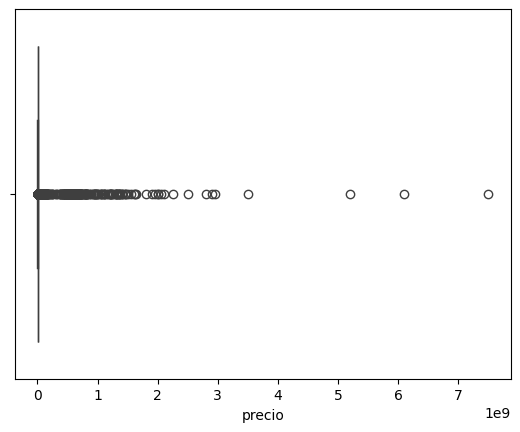

In [ ]:
sns.boxplot(x=df_limpio['precio'].round(0))
plt.xlim(0, 2)